# Forecast de Ventas 2026: Análisis por Tipo de Suscripción

**Objetivo:** Generar una proyección diaria de ventas (cantidad y/o ingresos) para el año 2026 basada en el histórico Agosto 2022 - Agosto 2025.

**Metodología:** Se utilizará el algoritmo **Prophet** (Meta), ideal para series de tiempo con fuerte estacionalidad y efectos de calendario.

**Datos de entrada:**
- Granularidad: Diaria
- Segmentación: `tipo_suscripcion`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Configuración visual para los gráficos
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.rcParams['figure.figsize'] = (15, 6)

print("Librerías cargadas correctamente.")

c:\Users\victor.briones\Documents\python_virtual_enviroments\exploratory_data_analysis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Librerías cargadas correctamente.


In [2]:
# 1. Cargar el dataset
# Asegúrate de que el archivo esté en la misma carpeta o coloca la ruta completa
nombre_archivo = '../data/data_forecast_2026/data_forecast_2026_silver/ingresos_membresia_3_dias_limpio.csv'  # <--- CAMBIA ESTO POR TU ARCHIVO REAL
df_main = pd.read_csv(nombre_archivo)

# 2. Conversión de fechas
df_main['fecha'] = pd.to_datetime(df_main['fecha'])

# 3. Verificación rápida
print(f"Rango de fechas: {df_main['fecha'].min()} a {df_main['fecha'].max()}")

display(df_main.head())

Rango de fechas: 2022-07-27 00:00:00 a 2025-11-30 00:00:00


,cantidad_Vendida,ingresos_totales_reales,fecha,ingresos_totales_reales_imputado
0,1,234.0,2022-07-27,234.0
1,1,234.0,2022-08-09,234.0
2,1,234.0,2022-08-10,234.0
3,8,1872.0,2022-08-13,1872.0
4,16,3744.0,2022-08-14,3744.0


Filtro para obtener muestra de datos

In [3]:
# *** PASO CRÍTICO: RENOMBRAR COLUMNAS ***
# Supongamos que tu csv tiene 'Fecha_Venta' y 'Total_Vendido'
df = df_main.rename(columns={'fecha': 'ds', 'ingresos_totales_reales_imputado': 'y'})

# Asegurar que 'ds' sea datetime
df['ds'] = pd.to_datetime(df['ds'])

Paso 3: Configurar y Entrenar el Modelo
- Aquí instanciamos la clase Prophet. Puedes agregar configuraciones extra aquí (como festivos).

Nota: Usé seasonality_mode='multiplicative' porque en ventas, cuando la tendencia crece, la estacionalidad suele crecer proporcionalmente (vendes más en Navidad año con año si tu empresa crece).

In [4]:
""" # Inicializar el modelo
# daily_seasonality=True si tienes datos por hora/minuto, si es por día, Prophet lo detecta solo.
m = Prophet(seasonality_mode='multiplicative') 

# Añadir festivos (Opcional pero recomendado para ventas)
m.add_country_holidays(country_name='MX') # Código de país (ej. MX, US, ES)

# Entrenar el modelo (Ajustar a los datos históricos)
m.fit(df) """

# Configuración personalizada para ventas volátiles
m = Prophet(
    changepoint_prior_scale=0.16,  # Hacemos la tendencia más flexible (detecta cambios rápidos)
    seasonality_prior_scale=10.0,  # Damos más peso a la estacionalidad
    seasonality_mode='multiplicative', # Las oscilaciones crecen si el negocio crece
    daily_seasonality=False,       # Apagamos estacionalidad diaria si solo tenemos datos por día
    yearly_seasonality=True        # Forzamos que busque patrones anuales
)

m.add_country_holidays(country_name='MX')
m.fit(df)


13:03:10 - cmdstanpy - INFO - Chain [1] start processing
13:03:10 - cmdstanpy - INFO - Chain [1] done processing


Paso 4: Crear el DataFrame Futuro
- Necesitamos crear una tabla vacía con las fechas futuras que queremos predecir.

In [5]:
# Crear fechas futuras para 365 días (1 año)
future = m.make_future_dataframe(periods=365, freq='D')

# Ver las últimas filas para confirmar que llegamos al futuro
print(future.tail())

             ds
1568 2026-11-26
1569 2026-11-27
1570 2026-11-28
1571 2026-11-29
1572 2026-11-30


Paso 5: Realizar la Predicción (Forecast)

In [6]:
# Predecir
forecast = m.predict(future)

# El resultado 'forecast' es un dataframe con muchas columnas.
# Nos interesan: 'ds', 'yhat' (predicción), 'yhat_lower' y 'yhat_upper' (intervalos de confianza)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

             ds          yhat   yhat_lower    yhat_upper
1568 2026-11-26   9292.904155  5145.592557  13365.517563
1569 2026-11-27  10985.419016  6520.967565  15059.551033
1570 2026-11-28  10191.998299  6518.385074  14485.865622
1571 2026-11-29   9586.147015  5656.392703  13661.061471
1572 2026-11-30   6055.271712  2183.403477   9784.864476


Paso 6: Visualización
- Prophet tiene herramientas de visualización integradas que son excelentes.

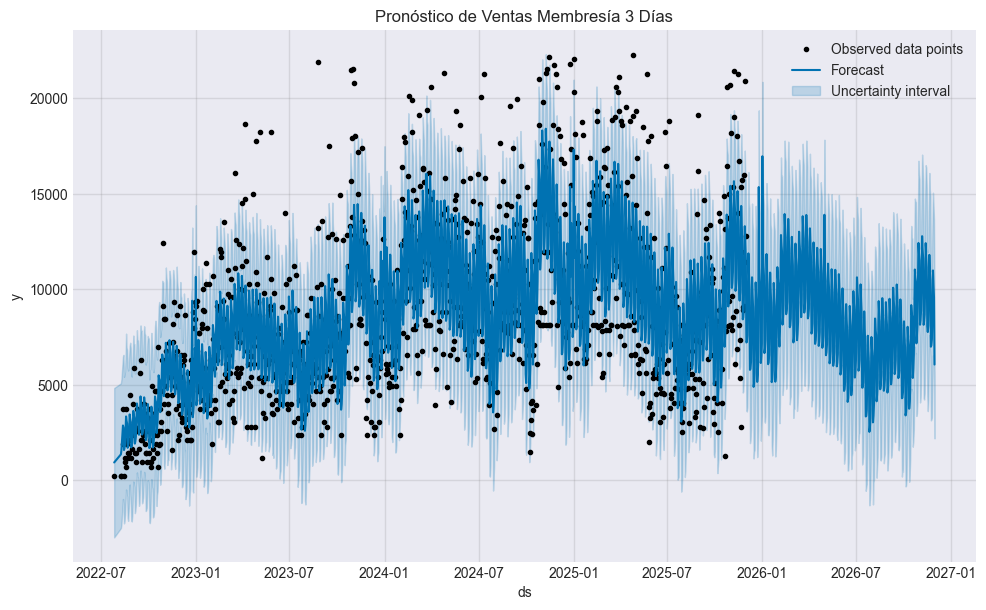

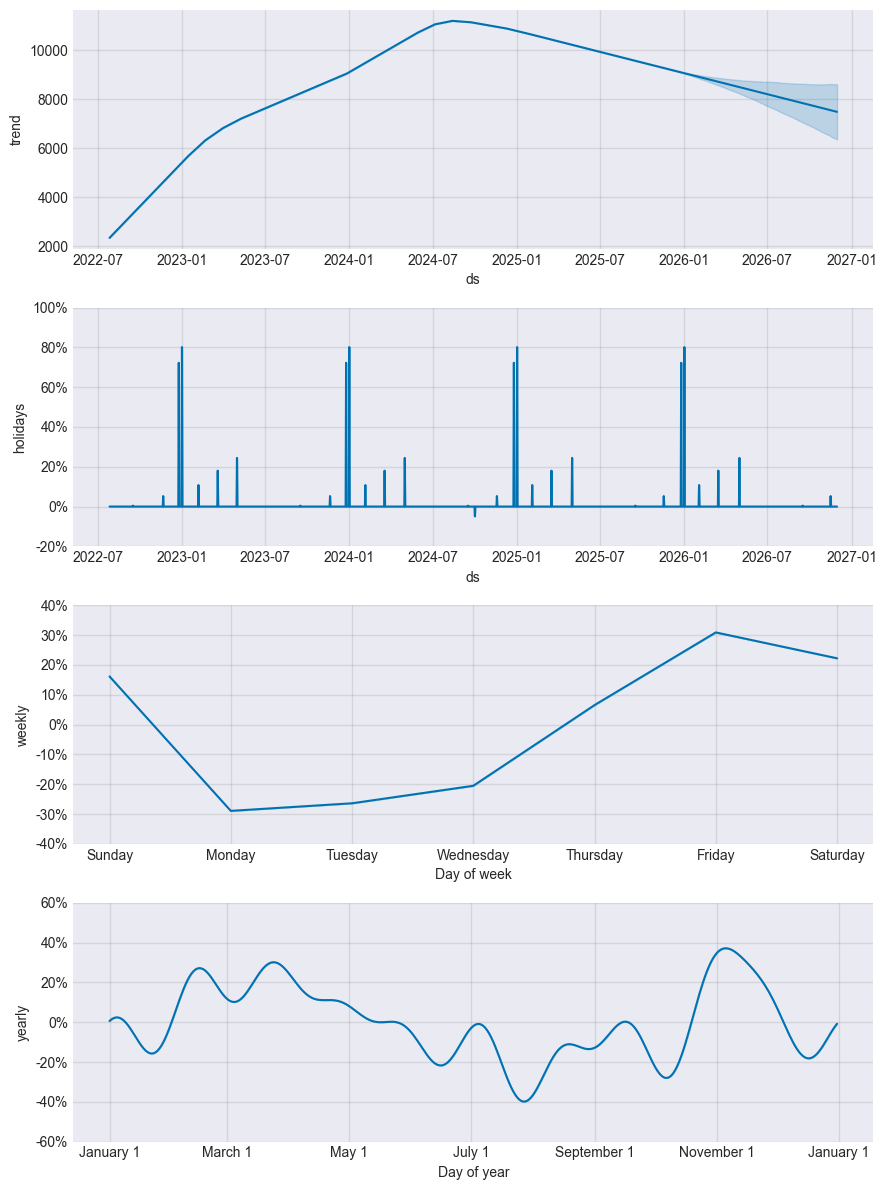

In [7]:
# 1. Gráfico principal: Puntos negros son datos reales, línea azul es la predicción
fig1 = m.plot(forecast)
plt.title("Pronóstico de Ventas Membresía 3 Días")
# mostrar leyenda
plt.legend()
plt.show()

# 2. Desglose de componentes: Muestra Tendencia, Semanal, Anual y Festivos por separado
fig2 = m.plot_components(forecast)
plt.show()

##### Agrupamos data por mes para su exportacion

In [8]:
# agrupar por mes y sumar yhat, yhat_lower, yhat_upper
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast['month'] = forecast['ds'].dt.to_period('M')
monthly_sales = forecast.groupby('month')[['yhat', 'yhat_lower', 'yhat_upper']].sum().round(2).reset_index()
print(monthly_sales)

      month       yhat  yhat_lower  yhat_upper
0   2022-07     925.85    -3001.25     4824.89
1   2022-08   49023.17   -31522.97   130244.56
2   2022-09   91638.16   -16429.81   202380.87
3   2022-10  116941.40     -174.41   236254.41
4   2022-11  171134.60    56593.92   286516.09
5   2022-12  150489.92    33892.55   267397.94
6   2023-01  166798.78    48373.01   285405.47
7   2023-02  206433.72    99921.03   312944.66
8   2023-03  250762.37   131994.20   369839.90
9   2023-04  240695.32   126630.79   354103.52
10  2023-05  224532.67   106249.86   342907.28
11  2023-06  195335.87    81465.67   309826.08
12  2023-07  193162.14    75628.50   310527.29
13  2023-08  199823.92    80996.61   317850.88
14  2023-09  234753.59   119924.88   348105.72
15  2023-10  245997.60   126450.71   363691.86
16  2023-11  335072.16   221028.73   449663.53
17  2023-12  265455.91   148778.65   383925.32
18  2024-01  268609.59   151469.25   387068.66
19  2024-02  330033.65   219844.29   442482.22
20  2024-03  

In [9]:
monthly_sales.to_csv("../data/data_forecast_2026/data_forecast_2026_gold/forecast_3_dias_2026_monthly.csv")

In [10]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='90 days')

# 2. Calcular métricas de error
df_p = performance_metrics(df_cv)

# 3. Ver el resultado (Las métricas más importantes)
print(df_p[['horizon', 'rmse', 'mape']].head())

  0%|          | 0/3 [00:00<?, ?it/s]

13:03:12 - cmdstanpy - INFO - Chain [1] start processing
13:03:12 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.67it/s]13:03:13 - cmdstanpy - INFO - Chain [1] start processing
13:03:13 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.67it/s]13:03:13 - cmdstanpy - INFO - Chain [1] start processing
13:03:13 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


  horizon         rmse      mape
0  9 days  3016.792271  0.309824
1 10 days  3452.949549  0.313157
2 11 days  3475.964539  0.325106
3 12 days  3578.723898  0.341733
4 13 days  3724.889684  0.362800
